# 532 Lec 8 - Notebook interactivity

You need to download this notebook to view images.

## Lecture learning goals

By the end of the lecture you will be able to:

1. Share interactive visualizations without running a full dashboard or Python.
2. Learn how to use widgets in Altair
3. Philosophize deeply about the differences between plots and widgets (if there are any???)
4. Embed entire dashboards in notebooks using the Panel library
5. Use ggplotly for interactivity and animation.


## Table of Contents

You can view the ToC by opening this in your local Jupyter Lab,
and downloading the ToC extension
by going to the Extension Manager tab in the left sidebar, searching for "toc", and clicking "install"
(I posted [a video about this on slack](https://ubc-mds.slack.com/archives/C24GEJS11/p1599940203406600) if you can't find the extension).

# Intro

In this lecture,
we will see how we can share interactive visualization with people not running Python,
without making them publicly available on a server.
One way to do this is with authentication in Dash https://dash.plotly.com/authentication,
but we can also develop embed interactivity in exported HTML notebooks,
which can be emailed to your collaborators.
This is great for smaller applications when there is no need for a full fledged dashboard

# Reading in data

In [1]:
import altair as alt
from vega_datasets import data
import pandas as pd

movies = (
    data.movies()
    .drop(columns=['US_DVD_Sales', 'Director', 'Source', 'Creative_Type'])
    .dropna(subset=['Running_Time_min', 'Major_Genre', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'MPAA_Rating'])
    .assign(Release_Year=lambda df: pd.to_datetime(df['Release_Date']).dt.year)
    .reset_index(drop=True))
movies

Title    US_Gross  Worldwide_Gross  \
0                  Broken Arrow  70645997.0      148345997.0   
1                        Brazil   9929135.0        9929135.0   
2                 The Cable Guy  60240295.0      102825796.0   
3                Chain Reaction  21226204.0       60209334.0   
4                     City Hall  20278055.0       20278055.0   
..                          ...         ...              ...   
973                   Zoolander  45172250.0       60780981.0   
974                  Zombieland  75590286.0       98690286.0   
975  Zack and Miri Make a Porno  31452765.0       36851125.0   
976         The Legend of Zorro  45575336.0      141475336.0   
977           The Mask of Zorro  93828745.0      233700000.0   

     Production_Budget Release_Date MPAA_Rating  Running_Time_min  \
0           65000000.0  Feb 09 1996           R             108.0   
1           15000000.0  Dec 18 1985           R             136.0   
2           47000000.0  Jun 14 1996       PG-13              95.0   
3           55000000.0  Aug 02 1996       PG-13             106.0   
4           40000000.0  Feb 16 1996           R             111.0   
..                 ...          ...         ...               ...   
973         28000000.0  Sep 28 2001       PG-13              89.0   
974         23600000.0  Oct 02 2009           R              87.0   
975         24000000.0  Oct 31 2008           R             101.0   
976         80000000.0  Oct 28 2005          PG             129.0   
977         65000000.0  Jul 17 1998       PG-13             136.0   

            Distributor   Major_Genre  Rotten_Tomatoes_Rating  IMDB_Rating  \
0      20th Century Fox        Action                    55.0          5.8   
1             Universal  Black Comedy                    98.0          8.0   
2         Sony Pictures        Comedy                    52.0          5.8   
3      20th Century Fox        Action                    13.0          5.2   
4         Sony Pictures         Drama                    55.0          6.1   
..                  ...           ...                     ...          ...   
973  Paramount Pictures        Comedy                    62.0          6.4   
974       Sony Pictures        Comedy                    89.0          7.8   
975       Weinstein Co.        Comedy                    65.0          7.0   
976       Sony Pictures     Adventure                    26.0          5.7   
977       Sony Pictures     Adventure                    82.0          6.7   

     IMDB_Votes  Release_Year  
0       33584.0          1996  
1       76635.0          1985  
2       51109.0          1996  
3       15817.0          1996  
4        9908.0          1996  
..          ...           ...  
973     69296.0          2001  
974     81629.0          2009  
975     55687.0          2008  
976     21161.0          2005  
977      4789.0          1998  

[978 rows x 13 columns]

In [2]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   977 non-null    object 
 1   US_Gross                978 non-null    float64
 2   Worldwide_Gross         978 non-null    float64
 3   Production_Budget       977 non-null    float64
 4   Release_Date            978 non-null    object 
 5   MPAA_Rating             978 non-null    object 
 6   Running_Time_min        978 non-null    float64
 7   Distributor             977 non-null    object 
 8   Major_Genre             978 non-null    object 
 9   Rotten_Tomatoes_Rating  978 non-null    float64
 10  IMDB_Rating             978 non-null    float64
 11  IMDB_Votes              978 non-null    float64
 12  Release_Year            978 non-null    int64  
dtypes: float64(7), int64(1), object(5)
memory usage: 99.5+ KB


# Bindings different elements to selection events in Altair

## Legends

We saw before how we could use the `bind` parameter 
of an altair selection
to link it to the legend of the plot.

In [3]:
select_genre = alt.selection_single(
    fields=['Major_Genre'], # limit selection to the Major_Genre field
    bind='legend')

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    color='Major_Genre',
    tooltip='Title',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_selection(select_genre)

alt.Chart(...)

## Dropdowns

Binding to the legend doesn't work that well in this case
since there are so many colors that the plot looks a bit messy.
Instead,
we could create a dropdown selection widget directly in Altair (`alt.binding_select`)
to let us choose categories without coloring the points.
Instead of binding `alt.selection_single` to the legend
we can pass along the dropdown we just created.

In [4]:
# The drop down requires an array of options, here we sort the genres alphabeitcally
genres = sorted(movies['Major_Genre'].unique())
dropdown = alt.binding_select(options=genres)

select_genre = alt.selection_single(
    fields=['Major_Genre'],
    bind=dropdown)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_selection(select_genre)

alt.Chart(...)

In [5]:
select_genre.to_dict

<bound method Selection.to_dict of Selection('selector002', SelectionDef({
  bind: BindRadioSelect({
    input: 'select',
    options: ['Action', 'Adventure', 'Black Comedy', 'Comedy', 'Concert/Performance', 'Documentary', 'Drama', 'Horror', 'Musical', 'Romantic Comedy', 'Thriller/Suspense', 'Western']
  }),
  fields: ['Major_Genre'],
  type: 'single'
}))>

In [6]:
# The drop down requires an array of options, here we sort the genres alphabeitcally
genres = sorted(movies['Major_Genre'].unique())
dropdown = alt.binding_select(options=genres)

select_genre = alt.selection_single(
    fields=['Major_Genre'],
    bind=dropdown)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
#     tooltip='Title',
    tooltip=alt.value(select_genre.Major_Genre)
#     opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_selection(select_genre)

alt.Chart(...)

Let's give our dropdown a better name
and set the default value for the selection.

In [7]:
# The drop down requires an array of options, here we sort the genres alphabeitcally
genres = sorted(movies['Major_Genre'].unique())
dropdown = alt.binding_select(name='Genre ', options=genres)

select_genre = alt.selection_single(
    fields=['Major_Genre'],
    bind=dropdown,
    init={'Major_Genre': 'Comedy'})

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_selection(select_genre)

alt.Chart(...)

## Dropdown and radio buttons

We could also add multiple widgets together,
by binding them to different fields in the selection.
Here we're adding a radio button for the MPAA rating to the plot above.

In [8]:
# The drop down requires an array of options, here we sort the genres alphabetically
genres = sorted(movies['Major_Genre'].unique())
dropdown_genre = alt.binding_select(name='Genre ', options=genres)

mpaa_rating = sorted(movies['MPAA_Rating'].unique())
dropdown_mpaa = alt.binding_radio(name='MPAA Rating ', options=mpaa_rating)

select_genre_and_mpaa = alt.selection_single(
    fields=['Major_Genre', 'MPAA_Rating'],
    bind={'Major_Genre': dropdown_genre, 'MPAA_Rating': dropdown_mpaa})

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(select_genre_and_mpaa, alt.value(0.7), alt.value(0.1))
).add_selection(select_genre_and_mpaa)

alt.Chart(...)

Here it would makes sense to sort the ratings according to their natural order
instead of alphabetically, but they are roughly the same.

## Slider

In addition to dropdowns and add radio buttons we can add sliders, and checkboxes,
but there are no multiselection dropdown or range sliders.
For multiple selections, we can instead use `selection_multi` on other plots or legends,
and for range sliders, we can use the `selection_interval` on another plot.

Let's explore the slider.

In [9]:
slider = alt.binding_range(name='Tomatometer ')
select_rating = alt.selection_single(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_rating, alt.value(0.7), alt.value(0.1))
).add_selection(select_rating)

alt.Chart(...)

The default behavior is to only filter points that are the exact values of the slider.
This is useful for selection widgets like the dropdown,
but for the slider we want to make comparisons
such as bigger and smaller than.
We can use `alt.datum` for this,
which let's us use columns from the data
inside comparisons and more complex expression in Altair,
where it is not possible to write the column name only
(this makes it clear that is the the column name
and not just a string of the same name
that is referenced in the expression).

In [10]:
slider = alt.binding_range(name='Tomatometer ')
select_rating = alt.selection_single(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        alt.datum.Rotten_Tomatoes_Rating < select_rating.Rotten_Tomatoes_Rating,
        alt.value(0.7), alt.value(0.1))
).add_selection(select_rating)

alt.Chart(...)

We can set an explicit start value to avoid that all points appear unselected at the start,
as well as define the range and step size for the slider.

In [11]:
slider = alt.binding_range(name='Tomatometer ', min=10, max=60, step=5)
select_rating = alt.selection_single(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider,
    init={'Rotten_Tomatoes_Rating': 15})

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        alt.datum.Rotten_Tomatoes_Rating < select_rating.Rotten_Tomatoes_Rating,
        alt.value(0.7), alt.value(0.1))
).add_selection(select_rating)

alt.Chart(...)

A more useful function of our slider would be to filter for the year.

In [12]:
slider = alt.binding_range(
    name='Year ', step=1,
    min=movies['Release_Year'].min(), max=movies['Release_Year'].max())
select_rating = alt.selection_single(
    fields=['Release_Year'],
    bind=slider,
    init={'Release_Year': 2000})

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        alt.datum.Release_Year < select_rating.Release_Year,
        alt.value(0.7), alt.value(0.1))
).add_selection(select_rating)

alt.Chart(...)

## Driving slider-like selections from another plot instead

The plot above has several problems.
Since there is no range slider,
we would have to add a second slider to filter a range of values.
And it is a bit unclear why the max is 2040,
I guess there is a mislabeled movie,
but can't be sure.
I also don't get any information about which years have the most releases.

Due to Altair's consistent interaction grammar,
we can bind a similar selection event
to a bar chart (or any chart type we want) instead of the slider,
and change it to an interval to be able to select a range of points.

In [13]:
select_year = alt.selection_single(
    fields=['Release_Year'],
    init={'Release_Year': 2000})

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='Release_Year',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)))

scatter_plot & bar_slider

alt.VConcatChart(...)

It is great to be able to see where most movies are along the year axis!
This bar plot is a much more informative driver of the selection event
compared to the slider.

Now let's switch it over an interval selection,
I will change from `fields` to `encodings` here,
to indicate that we only want to drag the interval along the x-axis
and use whatever column is on that axis.
I will also fix the formatting of the x-axis
to display years properly by using the `year()`
function on the date column directly
(similar to how we have used `sum()`, `mean()` etc before).

In [14]:
select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='year(Release_Date)',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)))

scatter_plot & bar_slider

alt.VConcatChart(...)

This is related to the discussion we had in the first lecture around 
"what is a dashboard",
including examples on how shopping sites etc
have many of the features that we traditionally associate with dashboards.

Now let's ask ourselves "What is a widget?".
Is there any distinct difference between this small plot
and the slider that disqualifies it from being called a widget?
At this point,
I think is mostly comes down to looks,
so let's make our bar selector appear more "widgety".

In [15]:
select_year = alt.selection_interval(encodings=['x'])

# Filter out a few of the extreme value to make it look better
movies_fewer_years = movies.query('1994 < Release_Year < 2030')
bar_slider = (
    alt.Chart(movies_fewer_years).mark_bar().encode(
    alt.X('year(Release_Date)', title='', axis=alt.Axis(grid=False)),
    alt.Y('count()', title='', axis=None))
    .properties(height=20, width=100)
    .add_selection(select_year))

scatter_plot = alt.Chart(movies_fewer_years).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)))

(scatter_plot & bar_slider).configure_view(strokeWidth=0)

alt.VConcatChart(...)

[If it looks like a duck... ](https://en.wikipedia.org/wiki/Duck_test) then it is a widget to me!

## Multi-dimensional legends

Realizing the mutual properties between what we traditionally refer to as plots and legends,
means that it is almost only your imagination that sets the limits.
For example,
legends are usually one-dimensional,
but it doesn't have to be that way!
Let's make a three dimensional legend and link two of those dimensions to a selection.
We will use the [Altair composition operator](https://altair-viz.github.io/user_guide/interactions.html#composing-multiple-selections) `&`
for triggering the condition only at the intersection of all selections.

In [16]:
# To make the final result  bit more elegant, I am filtering out a few low count categories
top_genres = movies_fewer_years['Major_Genre'].value_counts()[:5].index
mpaa_rating_clean = [rate for rate in mpaa_rating if rate != 'Not Rated']
movies_clean = movies_fewer_years.query('Major_Genre in @top_genres and MPAA_Rating in @mpaa_rating_clean')

select_genre_and_mpaa = alt.selection_multi(
    fields=['Major_Genre', 'MPAA_Rating'],
    empty='all',
    nearest=True)

multidim_legend = alt.Chart(movies_clean, title=alt.TitleParams(text='Genre and Rating', fontSize=10, dx=-15)).mark_point(filled=True).encode(
    alt.X('MPAA_Rating', title=''),
    alt.Y('Major_Genre', title='', axis=alt.Axis(orient='right')),
    alt.Size('count()', legend=None),
    alt.Color('Major_Genre', legend=None),
    opacity=alt.condition(select_genre_and_mpaa, alt.value(1), alt.value(0.2))
#     alt.Shape('MPAA_Rating', legend=None)
).add_selection(select_genre_and_mpaa).properties(width=100)


select_year = alt.selection_interval(empty='all', encodings=['x'])

# Filter out a few of the extreme value to make it look better
bar_slider = (
    alt.Chart(movies_clean, title=alt.TitleParams(text='Production year', fontSize=10, dx=-15)).mark_bar().encode(
    alt.X('year(Release_Date)', title='', axis=alt.Axis(grid=False),
          scale=alt.Scale(domain=[1995, 2012])),
    alt.Y('count()', title='', axis=None))
    .properties(height=20, width=100)
    .add_selection(select_year))

select_time = alt.selection_interval(empty='all', encodings=['x'])

# Filter out a few of the extreme value to make it look better
bar_slider_time = (
    alt.Chart(movies_clean, title=alt.TitleParams(text='Running time', fontSize=10, dx=-15)).mark_bar().encode(
    alt.X('Running_Time_min', title='', axis=alt.Axis(grid=False)),
    alt.Y('count()', title='', axis=None))
    .properties(height=20, width=100)
    .add_selection(select_time))

scatter_plot = alt.Chart(movies_clean).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    color='Major_Genre',
    tooltip='Title:N',
    opacity=alt.condition(
        select_year & select_genre_and_mpaa & select_time,
        alt.value(0.7), alt.value(0.1)))

(scatter_plot | (bar_slider & bar_slider_time & multidim_legend)).configure_view(strokeWidth=0)

alt.HConcatChart(...)

Building advanced layouts like this is not the most common use case for notebook interactivity
when it is focused on exploration.
However,
it can be nice to know how to implement these features
when creating a more polished notebook to share with someone.

# Using Panel to embed simple dashboards in notebooks

Although Altair's interaction grammar is a joy to work with,
it is limited to clientside interactions as we have discussed before.
You can filter your data,
but not perform any calculation you want like in Dash.
Panel is full dashboarding library that also has the capability to be embedded in a notebook as HTML.
The layout logic is based on bootstrap,
so you will be organizing your app in rows and columns,
just like we did in Dash.

Panel is not quite as feature filled as Dash,
and although it is capable of creating standalone dashboards,
it really shines when you just need a few widgets in your notebook,
especially when you want to share this with someone not running Python.
A good starting point to using panel is the `interact` function,
which is similar to how you have used ipywidgets in one of your other courses.

- Install the jupyterlab extension for it to work properly.
- https://panel.holoviz.org/user_guide/Deploy_and_Export.html
- https://panel.holoviz.org/user_guide/Interact.html

In [17]:
import panel as pn
from panel.interact import interact

# Only loading vega because I am using Altair with panel in the next cell
# Otherwise you could call the extension without any args
pn.extension('vega')

def f(x):
    return x

interact(f, x=10).embed(max_opts=100)

In [18]:
def scatter_plot(y_col, df=movies):
    # Plot the sorted and filtered data frame
    chart = alt.Chart(df).mark_point().encode(
        x='Running_Time_min',
        y=y_col)
    return chart

# Add dropdown menus
interact(scatter_plot, y_col=movies.select_dtypes('number').columns).embed(max_opts=100)

# Notebook interactivity with plotly in R

Plotly does not have an easily composable interaction grammar,
but instead makes a few specific functions available for us to use.
One of these lets us create animations,
which is very cool!
Plotly interactions work out of the box in RStudio (via the Htmlwidgets library),
and will work in the knitted notebooks.
They should also work in JupyterLab if you first install the [JupyterLab plotly extensions](https://plotly.com/python/getting-started/#jupyterlab-support).

## Legend interactivity

As we have seen before,
we get zooming and interactive legends by default in plotly
and if we put 2 plots together in a subplot
they share an interactive legend
(although with doubled glyphs in the legend).
There is also [a highlight function
that can be used to drive non-legend based selection between two plots](https://plotly-r.com/client-side-linking.html).


```r
library(ggplot2)
library(plotly)
library(dplyr)

# animal_names <- selected_data[[1]] %>% purrr::map_chr('text')
p <- ggplot(msleep) +
    aes(y = vore,
        fill = vore) +
    geom_bar(width = 0.6) +
    ggthemes::scale_fill_tableau()
p1 <- ggplotly(p, tooltip = 'text') %>% layout(dragmode = 'select')

p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total,
        color = vore,
        text = name) +
    geom_point() +
    scale_x_log10() +
    ggthemes::scale_color_tableau()
p2 <- ggplotly(p, tooltip = 'text') %>% layout(dragmode = 'select')

subplot(p1, p2)
```

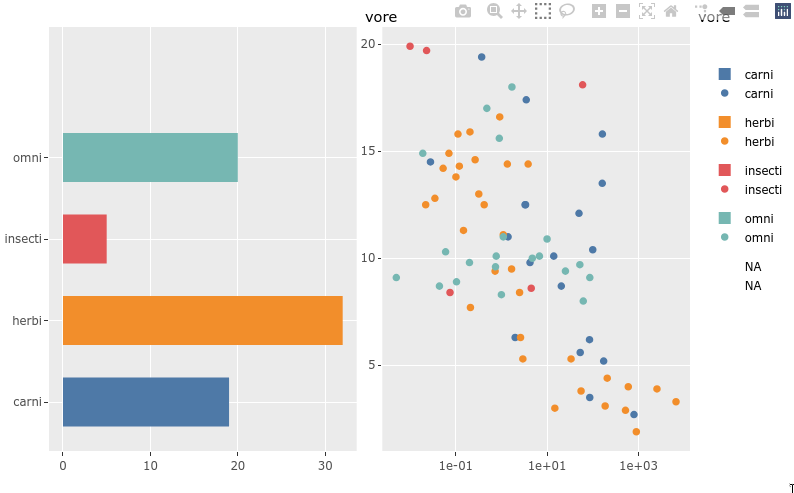

## Rangeslider

There is a built-in function for creating a small plot ([a rangeslider](https://plotly-r.com/improving-ggplotly.html))
that can be used as a zoom widget of the bigger plot.

```r
library(babynames)
library(dplyr)
library(ggplot2)
library(plotly)

nms <- filter(babynames, name %in% c("Sam", "Alex"))
range_p <- ggplot(nms) + 
    geom_line(aes(year, prop, color = sex, linetype = name))
  
ggplotly(range_p, dynamicTicks = TRUE) %>%
    rangeslider() %>%
    layout(hovermode = "x")
```

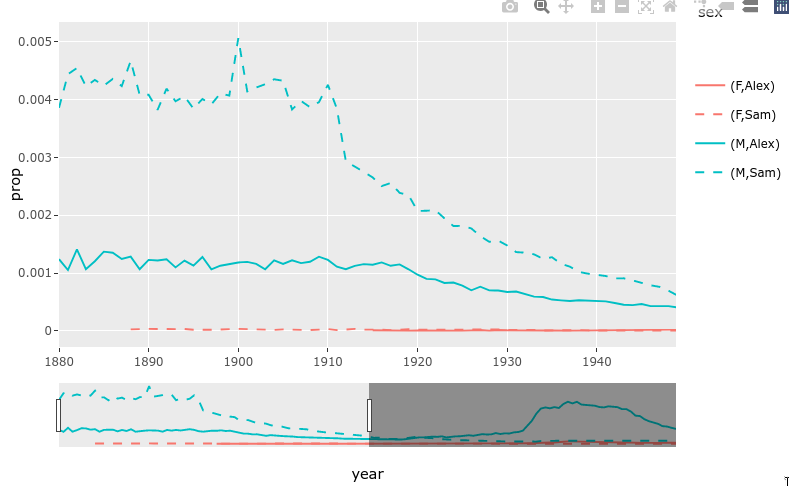

## Animations!

Animations are easily created by passing a column to the `frame` aesthetic in ggplot.

```r
library(plotly)
library(gapminder)


gap_p <- ggplot(gapminder, aes(gdpPercap, lifeExp, color = continent)) +
  geom_point(aes(size = pop, frame = year, ids = country)) +
  scale_x_log10()

ggplotly(gap_p)
```

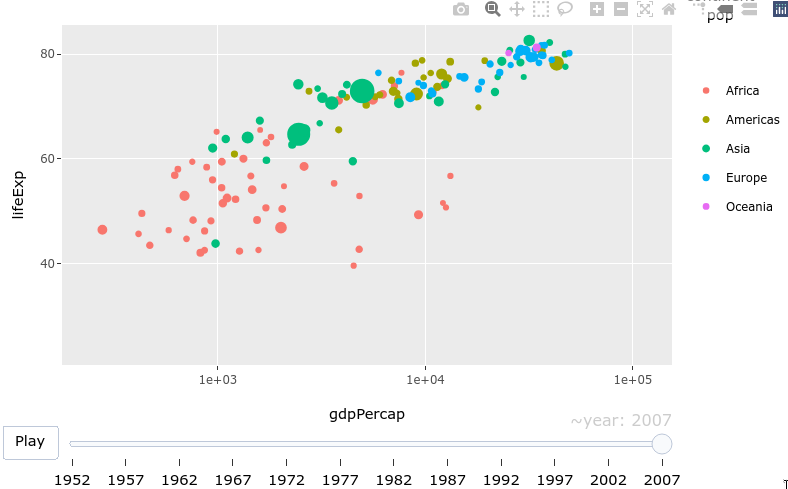

## Dropdowns

[Dropdowns are a bit verbose to use with plotlya](https://plotly.com/r/dropdowns/)
and [they cannot be used with ggpltoly to dynamically query and filter the data](https://github.com/ropensci/plotly/issues/803#issuecomment-264042783)
as we saw with the Altair plots.
They could be used to control properties of the plot aesthetics 
such as marker color or which column's plot is shown, [the same goes for sliders](https://plotly.com/r/sliders/))
here is an example of the latter with ggplotly:

```{r}
library(plotly)

dat <- mtcars
dat$cyl <- factor(dat$cyl)
dat$car <- rownames(mtcars)

dat %>% 
  tidyr::pivot_longer(c(mpg, hp, qsec)) %>% 
  plot_ly(x = ~car, y = ~value, color = ~cyl, symbol = ~name) %>%
  add_trace(type='scatter', mode='markers', name = ~cyl) %>% 
  layout(
    updatemenus = list(
      list(
        type = "list",
        label = 'Category',
        buttons = list(
          list(method = "restyle",
               args = list('visible', c(TRUE, FALSE, FALSE)),
               label = "hp"),
          list(method = "restyle",
               args = list('visible', c(FALSE, TRUE, FALSE)),
               label = "mpg"),
          list(method = "restyle",
               args = list('visible', c(FALSE, FALSE, TRUE)),
               label = "qsec")
        )
      )
    )
  )
```

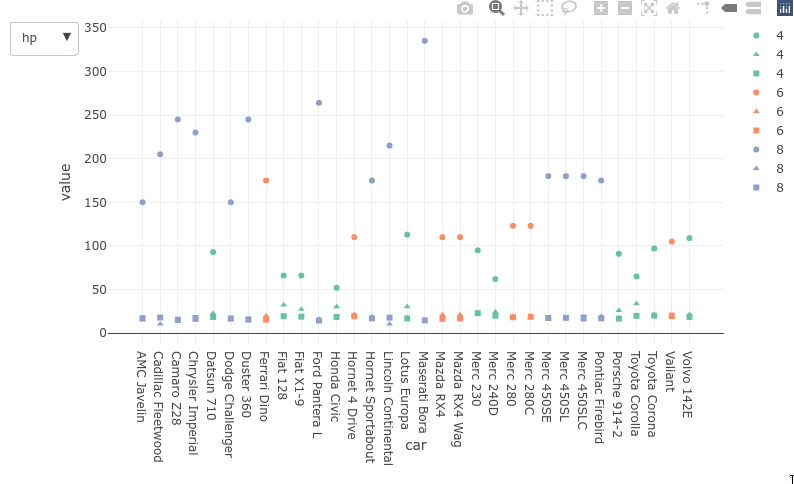